In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [14]:
spx_path = "data/SPX_database_2010.xlsx"
df_tri = pd.read_excel(spx_path, sheet_name="total_ret").set_index("Dates")
df_tri.index = pd.to_datetime(df_tri.index)

In [15]:
tickers = [
    "MSFT", "AAPL", "NVDA", "GOOGL", "IBM",
    "AVGO", "ADBE", "CRM", "INTC", "INTU",
    "UNH", "PFE", "LLY", "ABT", "MRK",
    "MCD", "AMZN", "COST", "SBUX", "PG",
    "JPM", "GS", "MS", "BLK", "CAT",
    "DE", "GE", "XOM", "NEE", "ETN"
]

def clean_column_names(df):
    new_columns = []
    for col in df.columns:
        if ' UN Equity' in str(col):
            ticker = col.split(' UN Equity')[0]
            new_columns.append(ticker)
        elif ' UW Equity' in str(col):
            ticker = col.split(' UW Equity')[0]
            new_columns.append(ticker)
        else:
            new_columns.append(col)
    return new_columns

df_tri.columns = clean_column_names(df_tri)

# tickers = [t for t in tickers if t in df_tri.columns]
print(tickers)

['MSFT', 'AAPL', 'NVDA', 'GOOGL', 'IBM', 'AVGO', 'ADBE', 'CRM', 'INTC', 'INTU', 'UNH', 'PFE', 'LLY', 'ABT', 'MRK', 'MCD', 'AMZN', 'COST', 'SBUX', 'PG', 'JPM', 'GS', 'MS', 'BLK', 'CAT', 'DE', 'GE', 'XOM', 'NEE', 'ETN']


In [16]:
prices = df_tri[tickers].sort_index()
daily_returns = prices.pct_change().dropna()
daily_returns = daily_returns.loc[:, ~daily_returns.columns.duplicated()]
daily_returns.head()

,MSFT,AAPL,NVDA,GOOGL,IBM,AVGO,ADBE,CRM,INTC,INTU,...,JPM,GS,MS,BLK,CAT,DE,GE,XOM,NEE,ETN
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.007213,-0.014223,-0.009954,-0.006775,-0.010876,-0.004478,-0.009852,-0.005979,-0.006550,-0.004972,...,0.001881,-0.002087,-0.010524,-0.011596,-0.010351,-0.011715,-0.018908,-0.014328,-0.015999,-0.008277
2014-01-03,-0.006728,-0.021965,-0.012016,-0.007288,0.005983,0.003778,-0.002194,0.004739,-0.000385,-0.001850,...,0.007730,0.007121,0.015469,0.004379,-0.000556,0.004432,-0.000727,-0.002406,0.001304,0.002914
2014-01-06,-0.020318,0.005454,0.013403,0.011138,-0.003429,-0.006811,-0.017577,-0.016147,-0.012415,-0.000785,...,0.005797,0.006849,0.003492,-0.000318,-0.013138,-0.008273,-0.008006,0.001508,0.000476,-0.004359
2014-01-07,0.006914,-0.006988,0.016410,0.019027,0.019946,0.009385,0.014627,0.013277,0.005106,0.017425,...,-0.011526,-0.006021,-0.003162,0.009201,0.003272,0.004449,0.001101,0.014148,0.007345,0.002123
2014-01-08,-0.017852,0.006165,0.013494,0.002316,-0.009172,0.015019,-0.001179,0.036215,-0.006251,-0.005582,...,0.009431,0.000841,0.001269,-0.000315,0.002361,-0.010741,-0.002932,-0.003266,0.003176,-0.003442


In [17]:
def annualize_return(mean_daily_return, trading_days=252):
    return (1 + mean_daily_return) ** trading_days - 1

def annualize_cov(daily_cov, trading_days=252):
    return daily_cov * trading_days

In [18]:
from scipy.optimize import minimize

# Cell: optimizer that takes cash_expected_return

def solve_dynamic_markowitz(expected_returns, cov_matrix, target_vol,
                            max_weight_asset=0.25, max_weight_cash=0.50,
                            cash_expected_return=0.0):
    """
    expected_returns: (n,) annualized expected returns for risky assets
    cov_matrix: (n, n) annualized covariance of risky assets
    cash_expected_return: annualized expected return for cash (from SOFR)
    """
    n_assets = len(expected_returns)
    
    # extend covariance to include cash
    extended_cov = np.zeros((n_assets + 1, n_assets + 1))
    extended_cov[:n_assets, :n_assets] = cov_matrix
    
    # risky + cash expected return
    extended_mu = np.append(expected_returns, cash_expected_return)
    
    # bounds
    bounds = [(0.0, max_weight_asset)] * n_assets + [(0.0, max_weight_cash)]
    
    # constraint: sum w = 1
    def cons_weights(w):
        return np.sum(w) - 1.0
    
    constraints = [{"type": "eq", "fun": cons_weights}]
    
    # vol constraint
    def cons_vol(w):
        port_var = np.dot(w, np.dot(extended_cov, w))
        port_vol = np.sqrt(port_var)
        return target_vol - port_vol
    
    constraints.append({"type": "ineq", "fun": cons_vol})
    
    # objective: maximize expected return
    def objective(w):
        return -np.dot(w, extended_mu)
    
    # initial guess
    x0 = np.array([min(1.0 / (n_assets + 1), max_weight_asset)] * n_assets + [0.0])
    x0[-1] = 1.0 - np.sum(x0[:-1])
    x0[-1] = min(x0[-1], max_weight_cash)
    if np.sum(x0) < 1.0:
        gap = 1.0 - np.sum(x0)
        x0[:-1] += gap / n_assets
    
    from scipy.optimize import minimize
    res = minimize(
        objective,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 500, "ftol": 1e-9, "disp": False}
    )
    
    if not res.success:
        # relax vol slightly
        relaxed_target = target_vol + 0.005
        def cons_vol_relaxed(w):
            port_var = np.dot(w, np.dot(extended_cov, w))
            port_vol = np.sqrt(port_var)
            return relaxed_target - port_vol
        constraints[-1] = {"type": "ineq", "fun": cons_vol_relaxed}
        res = minimize(
            objective,
            x0,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
            options={"maxiter": 500, "ftol": 1e-9, "disp": False}
        )
    
    return res.x, res.success


In [19]:
df_sofr = pd.read_excel("./data/sofr.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"])
df_sofr = df_sofr.set_index("Dates").sort_index()

df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) - 1


In [20]:
lookback_days = 120
rebal_freq = "M"
target_annual_vol = 0.08
max_weight_asset = 0.25
max_weight_cash = 0.50

# month-end rebal dates
month_ends = daily_returns.resample(rebal_freq).last().index

valid_rebal_dates = []
for d in month_ends:
    window = daily_returns.loc[:d].tail(lookback_days)
    if len(window) == lookback_days:
        valid_rebal_dates.append(d)
valid_rebal_dates = pd.DatetimeIndex(valid_rebal_dates)

valid_rebal_dates

/var/folders/hr/fgjvyv952td_t375nz5nkxtw0000gn/T/ipykernel_18785/1414689471.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_ends = daily_returns.resample(rebal_freq).last().index


DatetimeIndex(['2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31',
               ...
               '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28',
               '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
               '2025-07-31', '2025-08-31'],
              dtype='datetime64[ns]', length=135, freq=None)

In [21]:
daily_returns = daily_returns.loc[:, ~daily_returns.columns.duplicated()]
sofr_daily = df_sofr["Taxa_diaria"].reindex(daily_returns.index).ffill()

weights_history = {}
portfolio_returns = []

all_dates = daily_returns.index

for i, reb_date in enumerate(valid_rebal_dates):
    window = daily_returns.loc[:reb_date].tail(lookback_days)
    window = window.dropna(axis=1)
    cols_this_reb = pd.Index(window.columns).unique()
    window = window[cols_this_reb]
    if window.shape[1] < 2:
        continue
    
    mean_daily = window.mean()
    exp_ret_annual = (1 + mean_daily)**252 - 1
    
    daily_cov = window.cov()
    annual_cov = daily_cov * 252
    
    sofr_window = sofr_daily.loc[:reb_date].tail(lookback_days)
    cash_daily_mean = sofr_window.mean()
    cash_expected_annual = (1 + cash_daily_mean)**252 - 1
    
    w_opt, ok = solve_dynamic_markowitz(
        exp_ret_annual.values,
        annual_cov.values,
        target_annual_vol,
        max_weight_asset=max_weight_asset,
        max_weight_cash=max_weight_cash,
        cash_expected_return=cash_expected_annual
    )
    
    n_assets_this_reb = len(cols_this_reb)
    assert len(w_opt) == n_assets_this_reb + 1
    
    asset_names = list(cols_this_reb) + ["CASH"]
    weights_history[reb_date] = pd.Series(w_opt, index=asset_names)
    
    if i < len(valid_rebal_dates) - 1:
        next_reb_date = valid_rebal_dates[i + 1]
        period_dates = all_dates[(all_dates > reb_date) & (all_dates <= next_reb_date)]
    else:
        period_dates = all_dates[all_dates > reb_date]
    
    period_rets = daily_returns.loc[period_dates, cols_this_reb].fillna(0.0)
    
    period_sofr = sofr_daily.loc[period_dates].fillna(0.0)
    
    asset_part = period_rets.dot(w_opt[:-1])
    cash_part = period_sofr * w_opt[-1]
    port_rets = asset_part + cash_part
    port_rets.name = "portfolio"
    
    portfolio_returns.append(port_rets)

portfolio_returns = pd.concat(portfolio_returns).sort_index()
portfolio_returns.head()


Dates
2014-07-01    2.886185e-03
2014-07-02   -3.284486e-03
2014-07-03    5.817472e-04
2014-07-04    5.019989e-07
2014-07-07    4.816298e-04
Name: portfolio, dtype: float64

In [22]:
def performance_vs_sofr(portfolio_returns, sofr_daily):
    sof = sofr_daily.reindex(portfolio_returns.index).fillna(0.0)
    excess = portfolio_returns - sof
    ann_ret = (1 + portfolio_returns).prod() ** (252 / len(portfolio_returns)) - 1
    ann_vol = portfolio_returns.std() * np.sqrt(252)
    ann_excess = (1 + excess).prod() ** (252 / len(excess)) - 1
    sharpe = ann_excess / ann_vol if ann_vol > 0 else np.nan
    return ann_ret, ann_vol, ann_excess, sharpe


ann_ret, ann_vol, ann_excess, sharpe = performance_vs_sofr(portfolio_returns, sofr_daily)
print(f"Ann. return      : {ann_ret:.2%}")
print(f"Ann. vol         : {ann_vol:.2%}")
print(f"Ann. excess (rf) : {ann_excess:.2%}")
print(f"Sharpe vs SOFR   : {sharpe:.2f}")


Ann. return      : 16.29%
Ann. vol         : 11.02%
Ann. excess (rf) : 14.22%
Sharpe vs SOFR   : 1.29


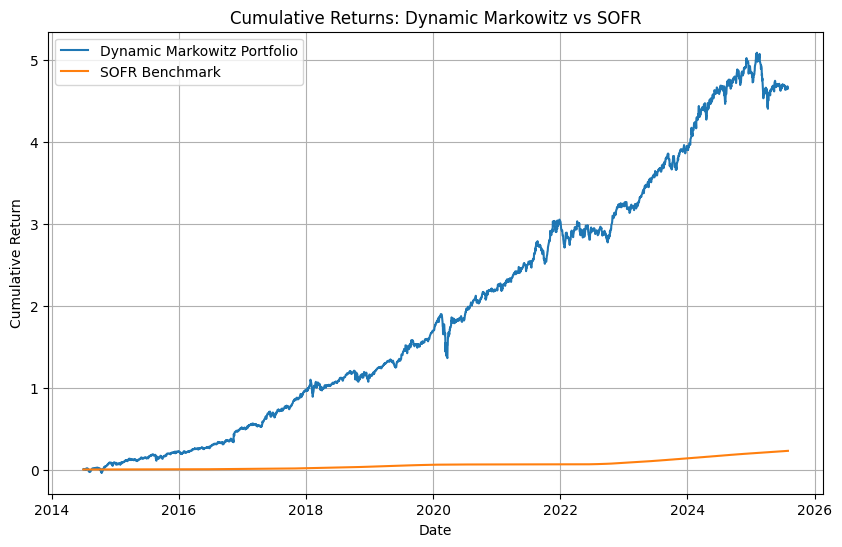

In [23]:
cum_port_ret = (1 + portfolio_returns).cumprod() - 1
cum_sofr = (1 + sofr_daily.reindex(portfolio_returns.index).fillna(
	0.0)).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(cum_port_ret, label="Dynamic Markowitz Portfolio")
plt.plot(cum_sofr, label="SOFR Benchmark")
plt.title("Cumulative Returns: Dynamic Markowitz vs SOFR")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [24]:
# Save cumulative returns to CSV
dynamic_cumulative_returns = pd.DataFrame({
    'Date': cum_port_ret.index,
    'Cumulative Return': cum_port_ret.values
})
dynamic_cumulative_returns.to_csv('results/dynamic_markowitz_cumulative_returns.csv', index=False)
print("Dynamic Markowitz cumulative returns saved to results/dynamic_markowitz_cumulative_returns.csv")

Dynamic Markowitz cumulative returns saved to results/dynamic_markowitz_cumulative_returns.csv
